In [22]:
image_path = 'C:\\Users\\jonat\\Downloads\\C16_10.8_C_01.tif'
ext_model_path = 'C:\\Users\\jonat\\PycharmProjects\\Titanium_Find_Contour_U-Net\\unet_model'
int_model_path = 'C:\\Users\\jonat\\PycharmProjects\\Titanium_Find_Contour_U-Net\\internal_smaller_mask_unet_model'

In [23]:
# Convert the image from format tif to png
from PIL import Image

im = Image.open(image_path)
im.save(image_path[:-3] + 'png')
image_path = image_path[:-3] + 'png'

In [24]:
import cv2
import os

img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, width = gray.shape
img = img[0:width, 0:width]
# replace the image with the new one
cv2.imwrite(image_path, img)

True

In [25]:
import numpy as np
import tensorflow as tf

def get_contour(mask: np.ndarray):
     # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # sDefine structuring element (MORPH_RECT)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    # Erosion using MORPH_RECT structuring element
    erosion= cv2.erode(thresh, kernel, iterations=1)
    # Dilate using MORPH_RECT structuring element
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

In [26]:
def get_heatmap(img, contour):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # create a mask with the contour
    mask = np.zeros(img_grey.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    #######################
    out = np.zeros_like(img)
    out[mask == 255] = img[mask == 255]
    img_color = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    ######################
    img_grey = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img_grey, (13,13), 0)
    #edges = cv2.Canny(blur, 50, 150)
    # Run Sobel filter on the original image
    sobelx = cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=5)
    sobely = cv2.Sobel(blur, cv2.CV_8U, 0, 1, ksize=5)
    # Find the magnitude of the gradient
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # Normalize the image
    sobel_magnitude = sobel_magnitude/sobel_magnitude.max()*255
    # Convert to uint8
    sobel_magnitude = np.uint8(sobel_magnitude)

    window_size = 201 # Odd number only
    window_step = 10

    heat_map_sobel = np.zeros(sobel_magnitude.shape, dtype=np.uint8)

    # pad the images with zeros
    sobel_c = np.pad(sobel_magnitude, int((window_size-1)/2), mode='constant', constant_values=0)
    mask_metal_c = np.pad(mask, int((window_size-1)/2), mode='constant', constant_values=0)

    for y in range(0, sobel_c.shape[0], window_step):
        for x in range(0, sobel_c.shape[1], window_step):
            window = sobel_c[y:y+window_size, x:x+window_size]
            mask_metal_window = mask_metal_c[y:y+window_size, x:x+window_size]/255
            if mask_metal_window.sum() == 0 or mask_metal_window[(int((window_size - 1) / 2)), (int((window_size - 1) / 2))] == 0:
                heat_map_sobel[y:y+window_size, x:x+window_size] = 0
            else:
                heat_map_sobel[y:y+window_step, x:x+window_step] = np.sum(window)/mask_metal_window.sum()

    heat_map_sobel = cv2.equalizeHist(heat_map_sobel)

    # # apply a threshold to remove low-intensity values
    # threshold = 50
    # heat_map_sobel[heat_map_sobel < threshold] = 0

    # Save the image with color map
    heat_map_sobel_tmp = heat_map_sobel.copy()
    heat_map_color_sobel = cv2.applyColorMap(heat_map_sobel_tmp, cv2.COLORMAP_JET)
    heat_map_color_sobel_rgb = cv2.applyColorMap(heat_map_color_sobel, cv2.COLOR_BGR2RGB)
    return heat_map_color_sobel

In [27]:
def crop_image(img, contour):
    # Create a mask with the contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    # Apply the mask to the image
    img = cv2.bitwise_and(img, mask)
    return img

In [28]:
# Load the models
ex_cnt_model = tf.keras.models.load_model(ext_model_path)
in_cnt_model = tf.keras.models.load_model(int_model_path)

In [29]:
# Load the original image
original_img = cv2.imread(image_path)

# Predict the external mask
ext_mask = predict_mask(original_img, ex_cnt_model)

# Crop the image using the external mask
ext_contour = get_contour(ext_mask)
ext_contour = ext_contour * (original_img.shape[0] / 128)
ext_contour = ext_contour.astype(np.int32)
cropped_img = crop_image(original_img, ext_contour)

1/1 [==============================] - 1s 1s/step


In [30]:
# Load the heatmap using the get_heatmap function
heatmap_img = get_heatmap(original_img, ext_contour)

In [31]:
# Find the internal mask
int_mask = predict_mask(heatmap_img, in_cnt_model)

# Find the internal contour
int_contour = get_contour(int_mask)
int_contour = int_contour * (original_img.shape[0] / 128)

1/1 [==============================] - 1s 1s/step


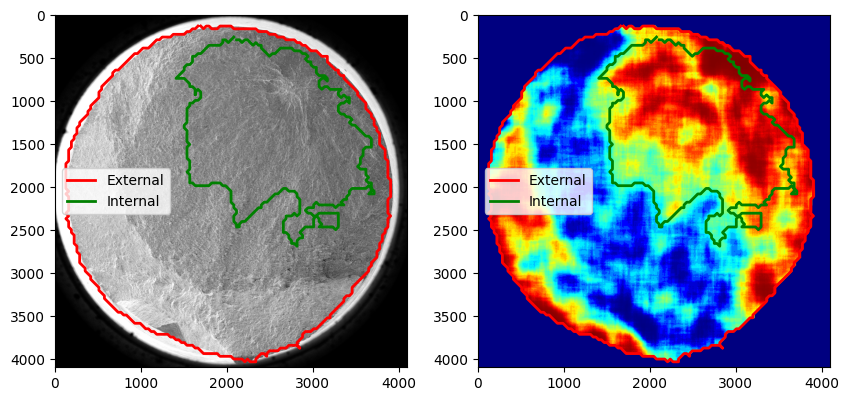

In [32]:
# plot the internal contour and external contour, on the original image and on the heatmap, and add a legend to distinguish betwwen external and internal
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
ax[0].imshow(original_img_rgb)
ax[0].plot(ext_contour[:, 0, 0], ext_contour[:, 0, 1], linewidth=2, color='red', label='External')
ax[0].plot(int_contour[:, 0, 0], int_contour[:, 0, 1], linewidth=2, color='green', label='Internal')
ax[0].legend()
heatmap_img_rgb = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
ax[1].imshow(heatmap_img_rgb)
ax[1].plot(ext_contour[:, 0, 0], ext_contour[:, 0, 1], linewidth=2, color='red', label='External')
ax[1].plot(int_contour[:, 0, 0], int_contour[:, 0, 1], linewidth=2, color='green', label='Internal')
ax[1].legend()
plt.show()

In [33]:
# Save the image with the contours
import os

save_path = os.path.dirname(image_path)
save_name = os.path.basename(image_path)
save_name = save_name[:-4] + '_contours.png'
save_path = os.path.join(save_path, save_name)
fig.savefig(save_path, dpi=300)